In [2]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import cm
import os
import re
from matplotlib import pyplot as plt

2024-06-09 09:34:06.636592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 09:34:06.636696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 09:34:06.766007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Будем использовать датасет с kaggle https://www.kaggle.com/competitions/sf-crime/overview
# Наша задача состоит в том, чтобы предсказать совершённое преступление по координатам и району Сан-Франциско

# Для начала прочитаем данные и посмотрим какой они природы 

In [77]:
train = pd.read_csv('/kaggle/input/crimes212/train.csv')
test = pd.read_csv('/kaggle/input/crimes-test12/test.csv')

# Датасет имеет следующие столбцы:
# Dates - дата совершения преступления
# Category - вид преступления
# Descript - описание преступления
# DayOfWeek - день недели, когда было совершено преступление
# Resolution - итог по преступлению
# Address, X, Y - адресс места преступления и его координаты 

In [4]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


# В нашам датасете не оказалось null, и все данные в столбцах это данные типа object (т.е. строчки), кроме координат места преступлений

# Наш датасет содержит 878049 записей о преступлениях, совершённых с 06.01.2003 по 13.05.2015

In [145]:
print(min(train['Dates']))
print(max(train['Dates']))
print(len(train))
print(len(train['Resolution'].unique()))
print(len(train['Address'].unique()))
print(len(train['PdDistrict'].unique()))
print(len(train['Descript'].unique()))

2003-01-06 00:01:00
2015-05-13 23:53:00
878049
17
23228
10
879


# Всего различных видов преступлений - 39

In [7]:
len(train['Category'].unique())

39

# Построим графики по нашим данным

# Посмотрим на расределение преступлений по их виду и на количество преступлений, совершаемое в разные дни

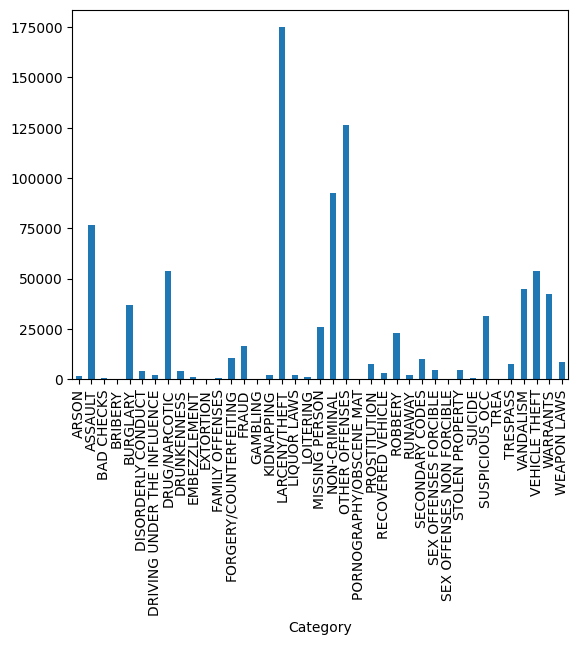

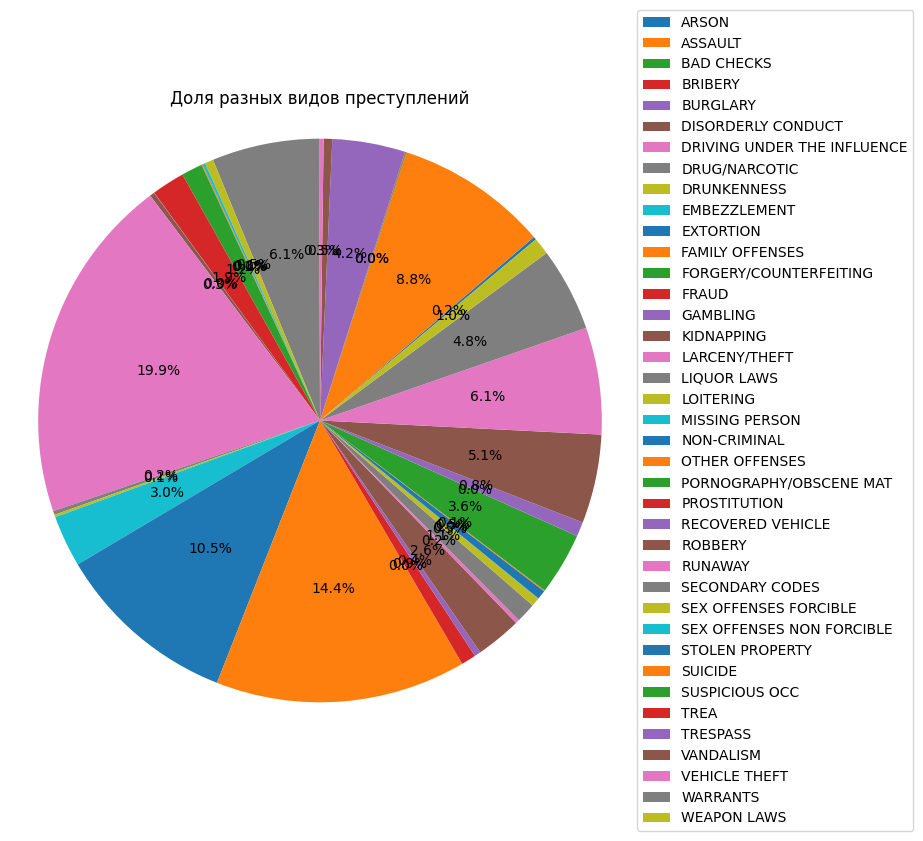

In [163]:
train_category = train.groupby('Category').count().iloc[:, 0]
train_category.plot.bar()
plt.show()
plt.figure(figsize=(8, 8))
plt.pie(train_category.values, autopct="%1.1f%%", startangle=40)
plt.axis("equal")
plt.title("Доля разных видов преступлений")
plt.legend(train_category.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

# Распределение преступлений по категориям:

In [11]:
train_category.describe()

count        39.000000
mean      22514.076923
std       38074.457249
min           6.000000
25%        1195.500000
50%        4388.000000
75%       28701.500000
max      174900.000000
Name: Dates, dtype: float64

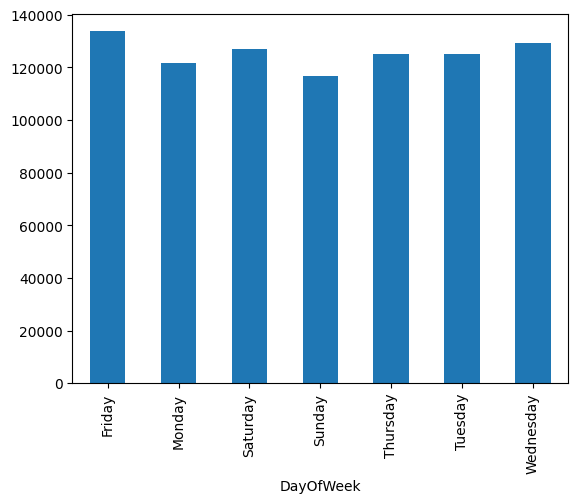

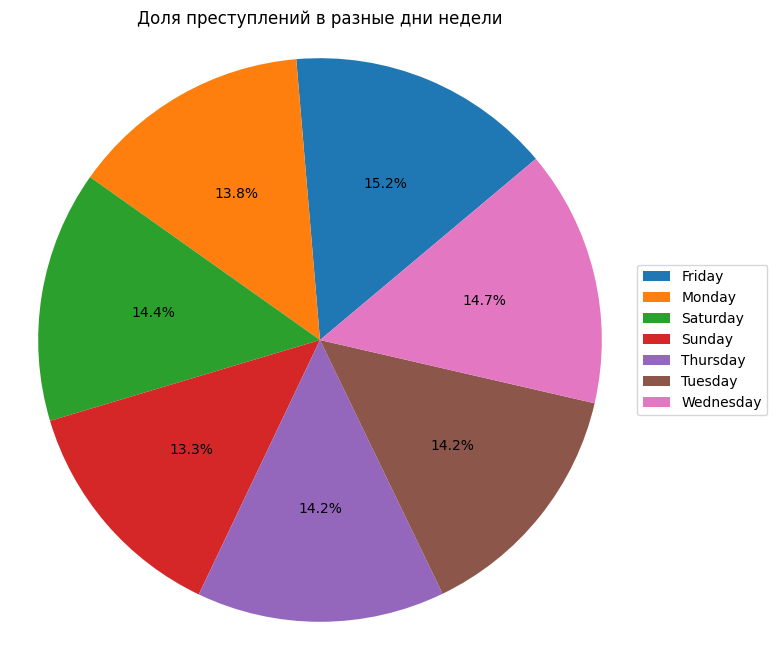

In [164]:
train_day = train.groupby('DayOfWeek').count().iloc[:, 0]
train_day.plot.bar()
plt.show()
plt.figure(figsize=(8, 8))
plt.pie(train_day.values, autopct="%1.1f%%", startangle=40)
plt.axis("equal")
plt.title("Доля преступлений в разные дни недели")
plt.legend(train_day.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

# Распределение преступлений по дням:

In [10]:
train_day.describe()

count         7.000000
mean     125435.571429
std        5422.313370
min      116707.000000
25%      123274.500000
50%      125038.000000
75%      128010.500000
max      133734.000000
Name: Dates, dtype: float64

# Видно, что преступления распределены примерно одинаково по дням

# Пока не используя geopandas, сами нарисуем карту Сан - Франциско, зная только координаты преступлений)

# Т.к. у нас есть координаты наших мест преступлений, то мы можем просто нанести их на карту, используя scatterplot

# (Будем использовать только 50000 наших координат, т.к. при бОльших количествах точек теряется информативность)

# Я стилизовал рисунок так, что преступления, совершённые в разные дни, помечаются разными фигурами, а разные виды преступлений - разными цветами

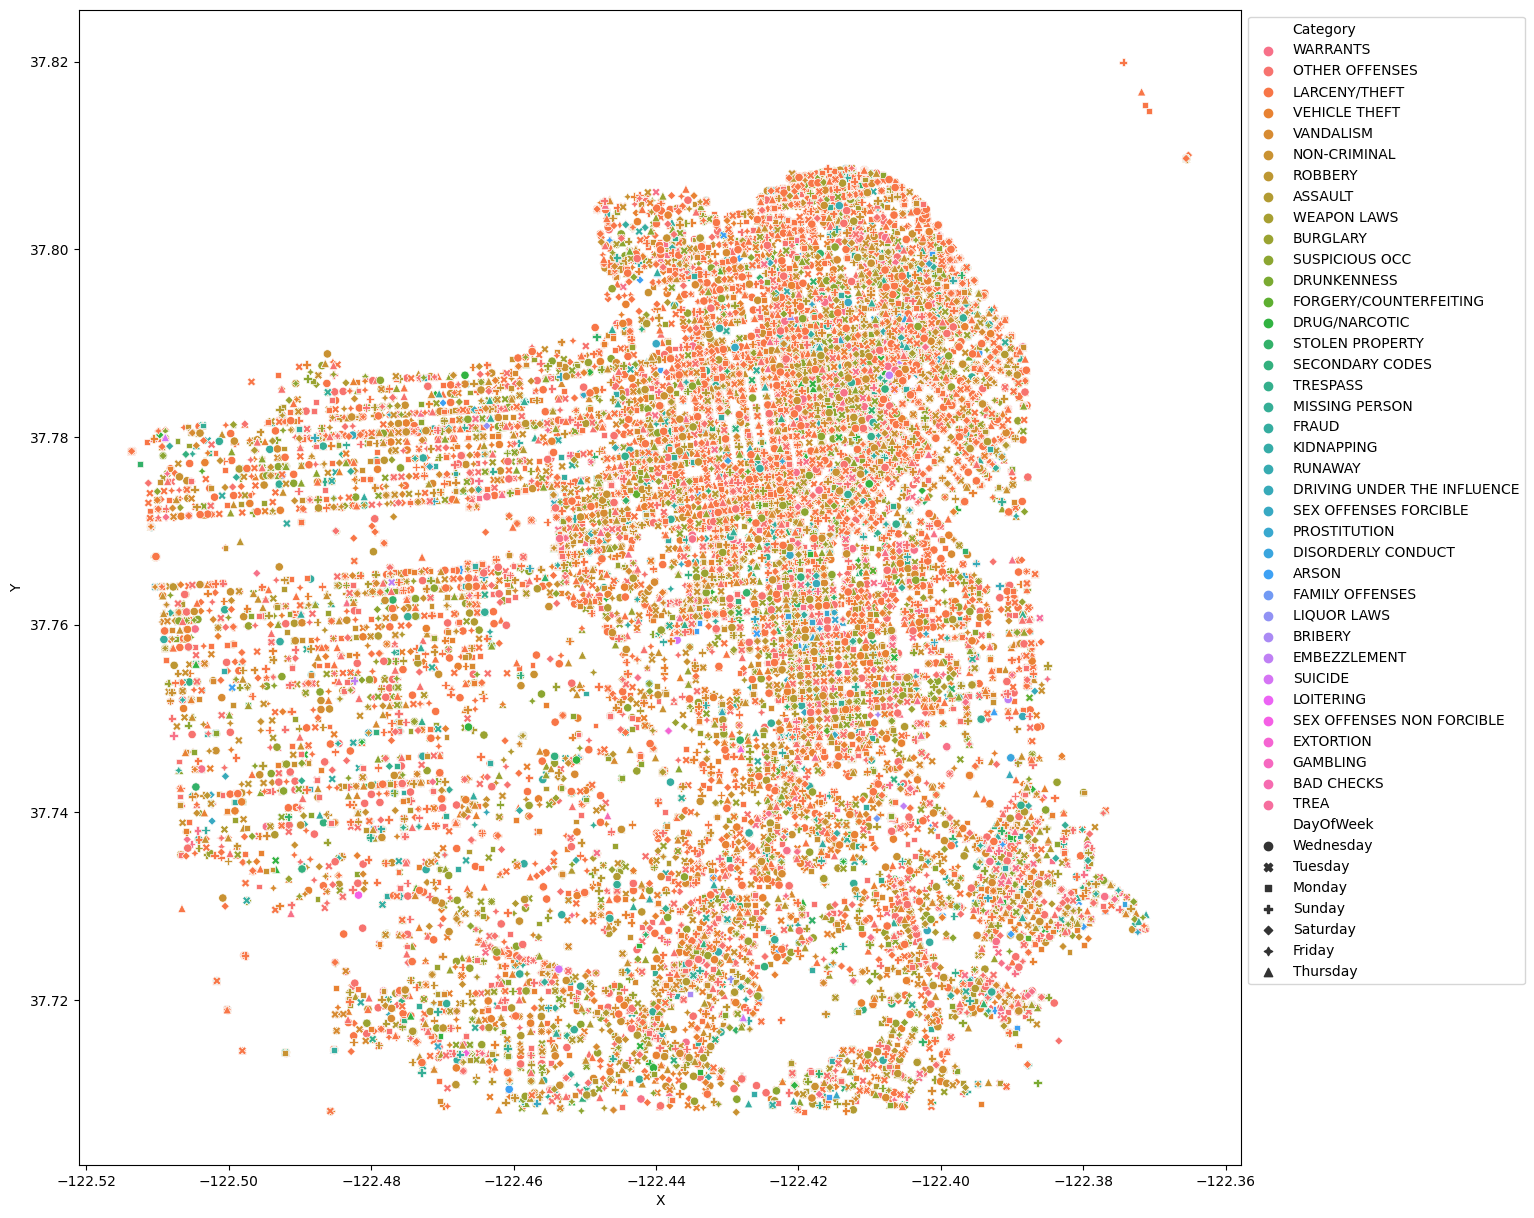

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.scatterplot(data=train.iloc[:50000], x='X', y='Y', hue="Category", style="DayOfWeek")
plt.legend(bbox_to_anchor=(1, 1))

# Используем геопандас и фолиум и нанесём наши координаты на карту мира и Сан-Франциско

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


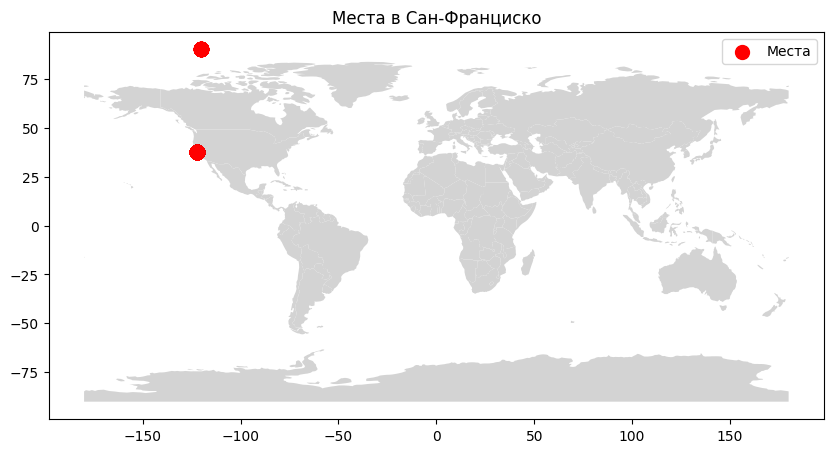

In [69]:
sf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

df = pd.DataFrame({
    'latitude': [i for i in train['Y']],
    'longitude': [i for i in train['X']]
})

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
sf.plot(ax=ax, color='lightgray')
gdf.plot(ax=ax, markersize=100, marker='o', color='red', label='Преступления')
ax.set_aspect('equal')
ax.set_title('Преступления в Сан-Франциско')
ax.legend()
plt.show()

# Видно, что некоторые точки оказались далеко за пределами Сан-Франциско
# Давайте посчитаем, сколько именно
# Давайте заменим эти точки средним значением по координатам совершенных преступлений, чтобы при обучении наша модель не обучалась на выбросах 
# Для этого с помощью numpy посчитаем среднее по датасету 

In [79]:
quantity = 0
X_mean = np.mean(train['X'])
Y_mean = np.mean(train['Y'])
for i in range(len(train['Y'])):
    if train['Y'][i] > 50:
        quantity += 1
        train.loc[i, 'Y'] = Y_mean
        train.loc[i, 'X'] = X_mean
print(quantity)

0


# Точек оказалось всего 67 штук (из 878049), поэтому замена на среднее кажется релевантной (выбросы очень немного влияют на это среднее)

# Так же давайте воспользуемся folium, чтобы получить интерактивную html карту с преступлениями
# (будем использовать 1000 преступлений, чтобы не перенагружать карту)

In [ ]:
import folium
import pandas as pd

coords = {
    'latitude': [i for i in train['Y']].iloc[:1000],
    'longitude': [i for i in train['X'].iloc[:1000]]
}

m = folium.Map(location=[37.8199, -122.4783], zoom_start=12)
for i, row in pd.DataFrame(coords).iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(m)
m.save('san_francisco_map.html')

# Теперь когда мы посмотрели на наши данные и предобработали их, то можно обучить предсказательную модель

# Для табличных данных отлично работают алгоритмы на деревьях, будем использовать градиентный бустинг (реализация из библиотеки catboost)

In [119]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split


X_train = train.drop(['Category', 'Descript', 'Resolution'], axis=1)
y_train = train['Category']
X_test = test.drop('Id', axis=1)

model = CatBoostClassifier(
    cat_features=['Dates', 'DayOfWeek', 'PdDistrict', 'Address'],
    iterations=10,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=False
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [141]:
prediction = y_pred
unique_values, counts = np.unique(prediction, return_counts=True)
print("Уникальные значения:")
print(unique_values)

print("Количество каждого уникального значения:")
print(dict(zip(unique_values, counts)))

Уникальные значения:
['ASSAULT' 'DRUG/NARCOTIC' 'LARCENY/THEFT' 'MISSING PERSON' 'NON-CRIMINAL'
 'OTHER OFFENSES' 'PROSTITUTION' 'VEHICLE THEFT']
Количество каждого уникального значения:
{'ASSAULT': 96272, 'DRUG/NARCOTIC': 73250, 'LARCENY/THEFT': 478705, 'MISSING PERSON': 12158, 'NON-CRIMINAL': 32954, 'OTHER OFFENSES': 182855, 'PROSTITUTION': 6156, 'VEHICLE THEFT': 1912}


Нарисуем графики по этим данным

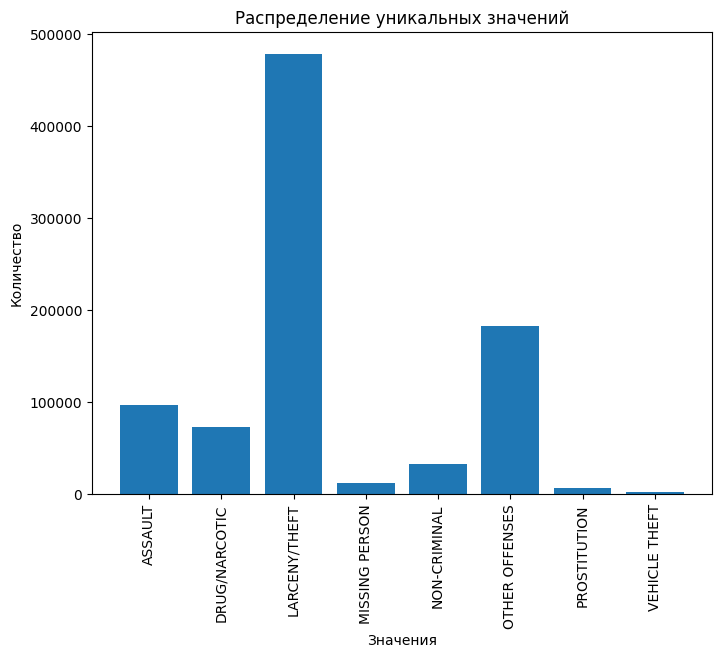

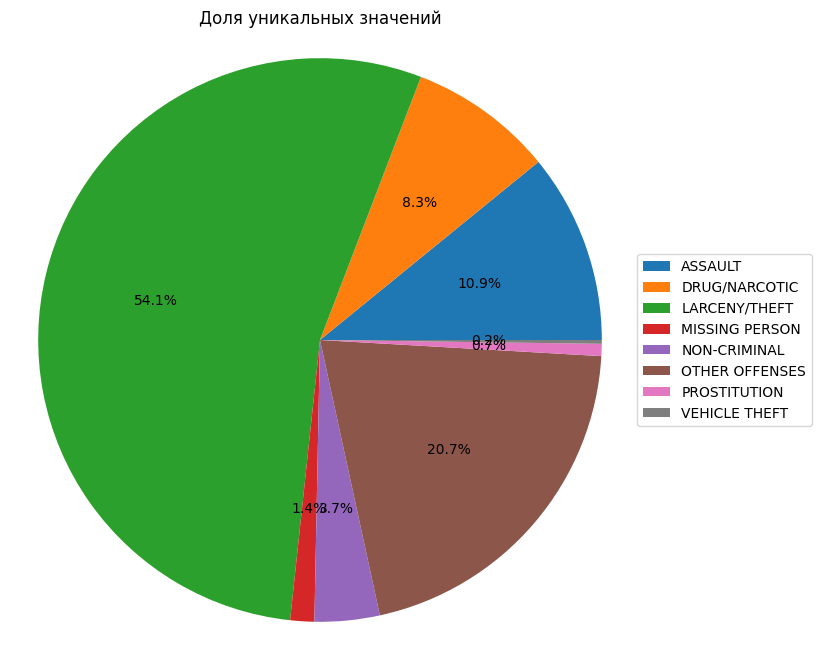

In [166]:
plt.figure(figsize=(8, 6))
plt.bar(unique_values, counts)
plt.xticks(unique_values, rotation=90)
plt.xlabel("Значения")
plt.ylabel("Количество")
plt.title("Распределение уникальных значений")
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(counts, autopct="%1.1f%%")
plt.axis("equal")
plt.title("Доля уникальных значений")
plt.legend(unique_values, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

# Модель с 10 деревьями в градиентном бустинге обучалась 30мин, но даже 10 деревьев дают разнообразие в ответах.
# Заметим, что модель работает неплохо, ведь она сохраняет пропорции, которые были в тестовом датасете, хоть и не предсказывает все преступления (из-за малого количества итераций улучшения в градиентном бустинге)